# Лабораторная работа 6


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, adjusted_rand_score
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
%matplotlib inline


In [2]:
import ssl
import urllib.request
from io import StringIO

def pd_read_csv_no_ssl(url, **kwargs):
    context = ssl._create_unverified_context()
    with urllib.request.urlopen(url, context=context) as response:
        data = response.read().decode()
        return pd.read_csv(StringIO(data), **kwargs)

try:
    url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00571/hcvdat0.csv'
    df = pd_read_csv_no_ssl(url)
    print(f"Данные успешно загружены. Размер: {df.shape}")
except Exception as e1:
    try:
        url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/hcv.csv'
        df = pd_read_csv_no_ssl(url, header=None)
        print(f"Данные загружены альтернативным способом. Размер: {df.shape}")
    except Exception as e2:
        print(f"Ошибка загрузки: {e2}")
        print("Попытка загрузить локальный файл...")
        try:
            df = pd.read_csv('hcvdat0.csv')
            print(f"Данные загружены из локального файла. Размер: {df.shape}")
        except Exception as e3:
            raise FileNotFoundError("Не удалось загрузить датасет. Пожалуйста, скачайте его вручную с http://archive.ics.uci.edu/dataset/571/hcv+data")

Данные успешно загружены. Размер: (615, 14)


In [3]:
print("Первые строки датасета:")
df.head()

Первые строки датасета:


,Unnamed: 0,Category,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
0,1,0=Blood Donor,32,m,38.5,52.5,7.7,22.1,7.5,6.93,3.23,106.0,12.1,69.0
1,2,0=Blood Donor,32,m,38.5,70.3,18.0,24.7,3.9,11.17,4.80,74.0,15.6,76.5
2,3,0=Blood Donor,32,m,46.9,74.7,36.2,52.6,6.1,8.84,5.20,86.0,33.2,79.3
3,4,0=Blood Donor,32,m,43.2,52.0,30.6,22.6,18.9,7.33,4.74,80.0,33.8,75.7
4,5,0=Blood Donor,32,m,39.2,74.1,32.6,24.8,9.6,9.15,4.32,76.0,29.9,68.7


In [4]:
print("\nИнформация о данных:")
df.info()


Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 615 entries, 0 to 614
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  615 non-null    int64  
 1   Category    615 non-null    object 
 2   Age         615 non-null    int64  
 3   Sex         615 non-null    object 
 4   ALB         614 non-null    float64
 5   ALP         597 non-null    float64
 6   ALT         614 non-null    float64
 7   AST         615 non-null    float64
 8   BIL         615 non-null    float64
 9   CHE         615 non-null    float64
 10  CHOL        605 non-null    float64
 11  CREA        615 non-null    float64
 12  GGT         615 non-null    float64
 13  PROT        614 non-null    float64
dtypes: float64(10), int64(2), object(2)
memory usage: 67.4+ KB


In [5]:
print("\nОписательная статистика:")
df.describe()


Описательная статистика:


,Unnamed: 0,Age,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
count,615.000000,615.000000,614.000000,597.000000,614.000000,615.000000,615.000000,615.000000,605.000000,615.000000,615.000000,614.000000
mean,308.000000,47.408130,41.620195,68.283920,28.450814,34.786341,11.396748,8.196634,5.368099,81.287805,39.533171,72.044137
std,177.679487,10.055105,5.780629,26.028315,25.469689,33.090690,19.673150,2.205657,1.132728,49.756166,54.661071,5.402636
min,1.000000,19.000000,14.900000,11.300000,0.900000,10.600000,0.800000,1.420000,1.430000,8.000000,4.500000,44.800000
25%,154.500000,39.000000,38.800000,52.500000,16.400000,21.600000,5.300000,6.935000,4.610000,67.000000,15.700000,69.300000
50%,308.000000,47.000000,41.950000,66.200000,23.000000,25.900000,7.300000,8.260000,5.300000,77.000000,23.300000,72.200000
75%,461.500000,54.000000,45.200000,80.100000,33.075000,32.900000,11.200000,9.590000,6.060000,88.000000,40.200000,75.400000
max,615.000000,77.000000,82.200000,416.600000,325.300000,324.000000,254.000000,16.410000,9.670000,1079.100000,650.900000,90.000000


In [6]:
df_original = df.copy()
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
df_numeric = df[numeric_cols].copy()
df_clean = df_numeric.dropna()

print(f"Исходный размер: {df.shape}")
print(f"После очистки: {df_clean.shape}")
print(f"\nЧисловые столбцы: {list(df_clean.columns)}")


Исходный размер: (615, 14)
После очистки: (589, 12)

Числовые столбцы: ['Unnamed: 0', 'Age', 'ALB', 'ALP', 'ALT', 'AST', 'BIL', 'CHE', 'CHOL', 'CREA', 'GGT', 'PROT']


## 1. С помощью матрицы диаграмм рассеяния визуализировать данные


In [7]:
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_clean), columns=df_clean.columns)

features_to_plot = df_scaled.columns.tolist()
n_features = len(features_to_plot)
features_to_plot

['Unnamed: 0',
 'Age',
 'ALB',
 'ALP',
 'ALT',
 'AST',
 'BIL',
 'CHE',
 'CHOL',
 'CREA',
 'GGT',
 'PROT']

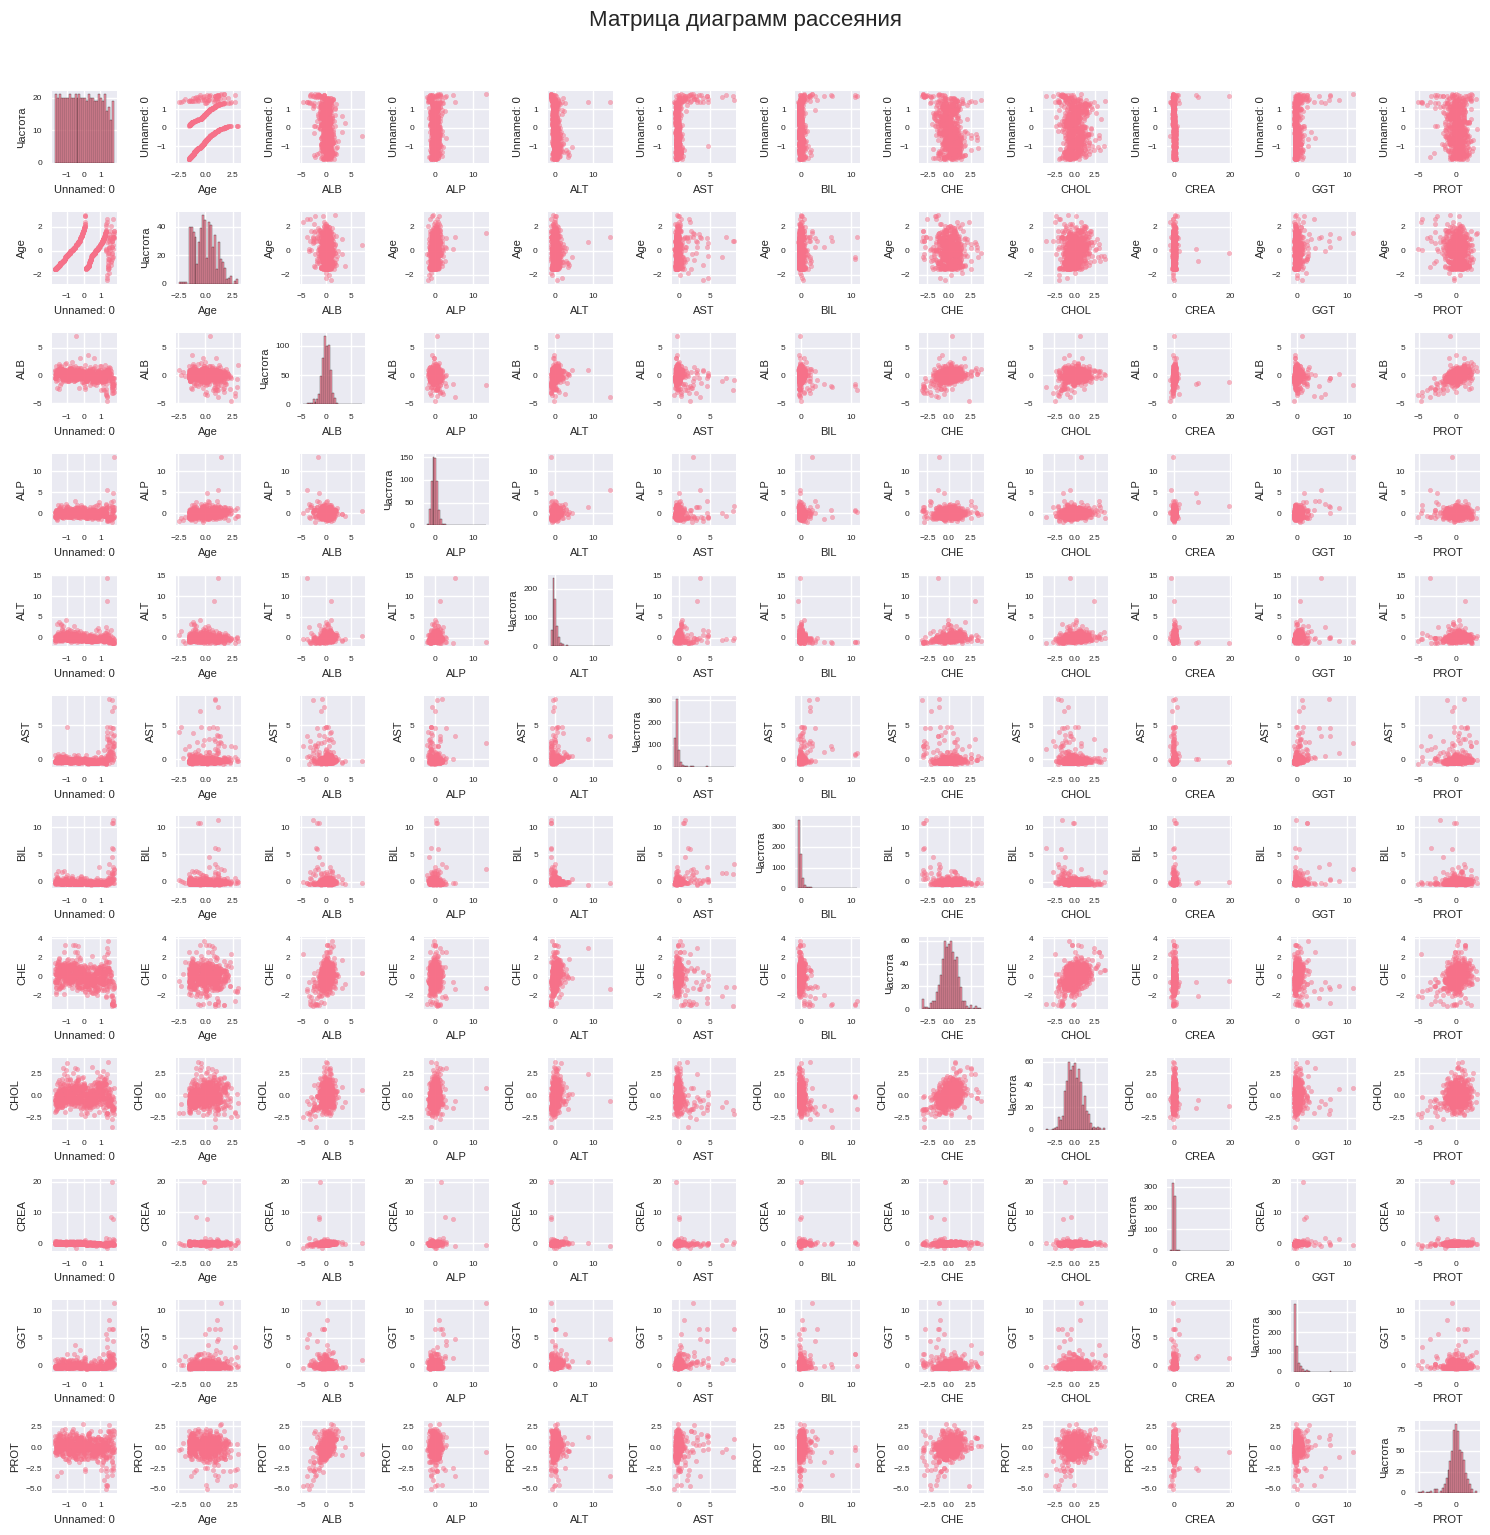

In [8]:
fig, axes = plt.subplots(n_features, n_features, figsize=(15, 15))
fig.suptitle('Матрица диаграмм рассеяния', fontsize=16, y=1.02)

for i in range(n_features):
    for j in range(n_features):
        ax = axes[i, j]
        if i == j:
            ax.hist(df_scaled[features_to_plot[i]], bins=30, alpha=0.7, edgecolor='black')
            ax.set_xlabel(features_to_plot[i], fontsize=8)
            ax.set_ylabel('Частота', fontsize=8)
        else:
            ax.scatter(df_scaled[features_to_plot[j]], df_scaled[features_to_plot[i]],
                     alpha=0.5, s=10)
            ax.set_xlabel(features_to_plot[j], fontsize=8)
            ax.set_ylabel(features_to_plot[i], fontsize=8)
        ax.tick_params(labelsize=6)

plt.tight_layout()
plt.show()

## 2. С помощью SVD, создать два производных признака и визуализировать данные в них (диаграммой рассеяния)


In [9]:
svd = TruncatedSVD(n_components=2, random_state=42)
X_svd = svd.fit_transform(df_scaled)

explained_variance = svd.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

print(f"Объясненная дисперсия первой компоненты: {explained_variance[0]:.4f} ({explained_variance[0]*100:.2f}%)")
print(f"Объясненная дисперсия второй компоненты: {explained_variance[1]:.4f} ({explained_variance[1]*100:.2f}%)")
print(f"Суммарная объясненная дисперсия: {cumulative_variance[1]:.4f} ({cumulative_variance[1]*100:.2f}%)")

df_svd = pd.DataFrame(X_svd, columns=['SVD_1', 'SVD_2'])


Объясненная дисперсия первой компоненты: 0.2266 (22.66%)
Объясненная дисперсия второй компоненты: 0.1547 (15.47%)
Суммарная объясненная дисперсия: 0.3813 (38.13%)


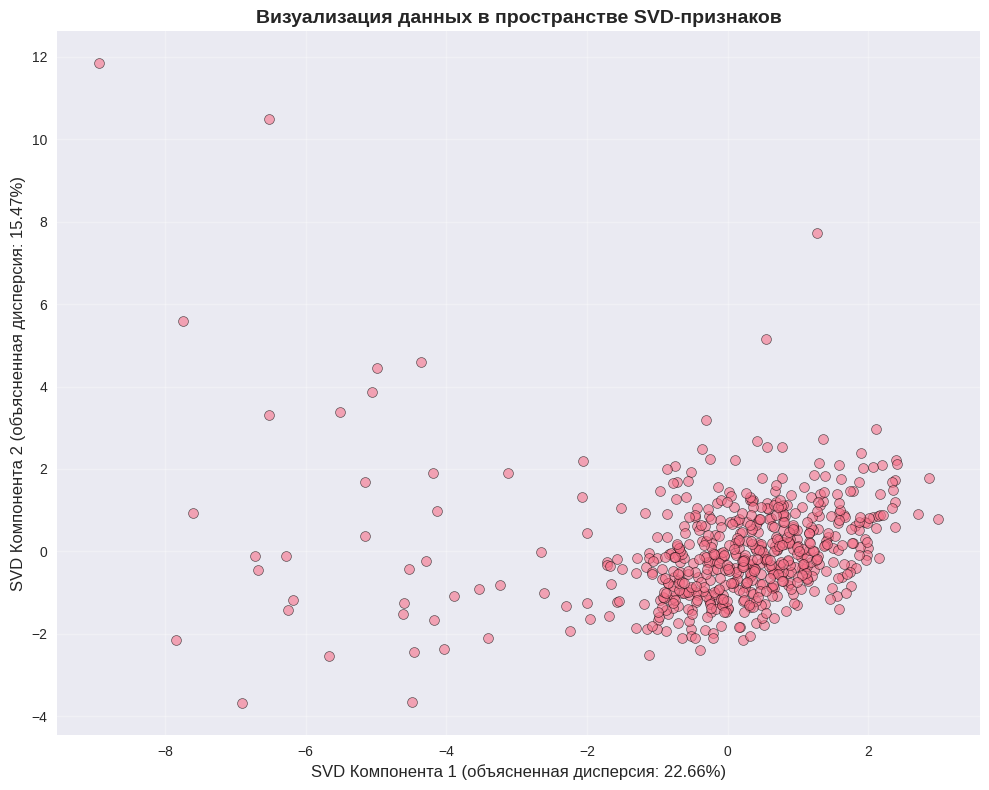

In [10]:
plt.figure(figsize=(10, 8))
plt.scatter(X_svd[:, 0], X_svd[:, 1], alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
plt.xlabel(f'SVD Компонента 1 (объясненная дисперсия: {explained_variance[0]*100:.2f}%)', fontsize=12)
plt.ylabel(f'SVD Компонента 2 (объясненная дисперсия: {explained_variance[1]*100:.2f}%)', fontsize=12)
plt.title('Визуализация данных в пространстве SVD-признаков', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## 3. По пп.2-3 определить потенциальное число кластеров.


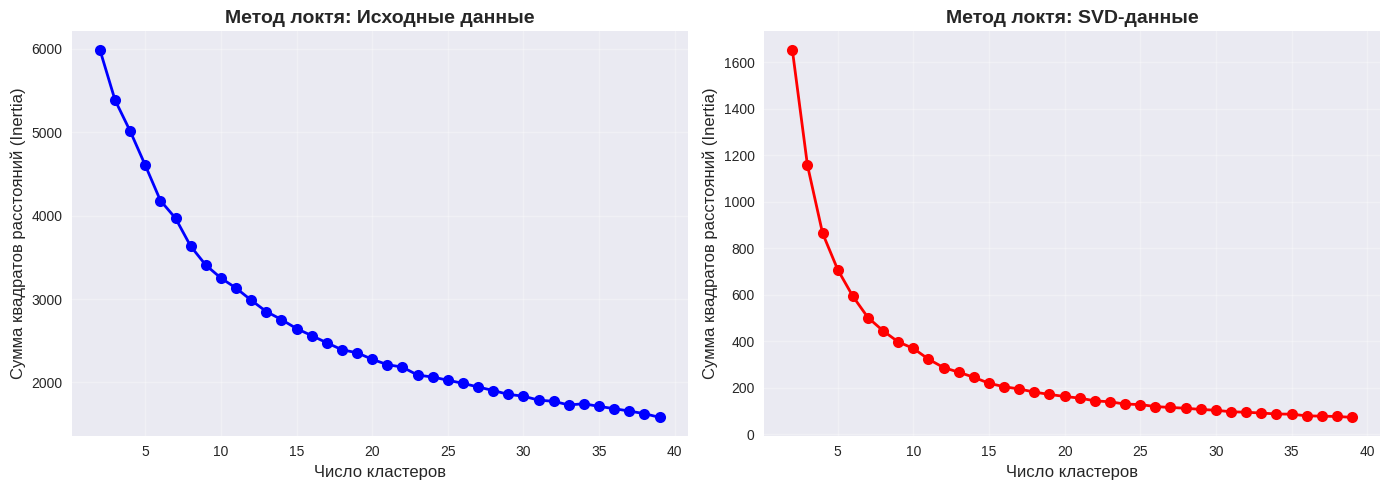

In [11]:
K_range = range(2, 40)

inertias_original = []
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_scaled)
    inertias_original.append(kmeans.inertia_)

inertias_svd = []
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_svd)
    inertias_svd.append(kmeans.inertia_)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(K_range, inertias_original, 'bo-', linewidth=2, markersize=8)
ax1.set_xlabel('Число кластеров', fontsize=12)
ax1.set_ylabel('Сумма квадратов расстояний (Inertia)', fontsize=12)
ax1.set_title('Метод локтя: Исходные данные', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

ax2.plot(K_range, inertias_svd, 'ro-', linewidth=2, markersize=8)
ax2.set_xlabel('Число кластеров', fontsize=12)
ax2.set_ylabel('Сумма квадратов расстояний (Inertia)', fontsize=12)
ax2.set_title('Метод локтя: SVD-данные', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Оптимальное число кластеров где то 38 -- в этой точке кривая начинает выравниваться


## 4. Используя алгоритм кластеризации GMM и исходные данные:


In [12]:
def calculate_r2_score(X, labels, centers):
    """
    Вычисляет R² для кластеризации.
    R² = 1 - (SS_within / SS_total)
    """
    X_mean = np.mean(X, axis=0)
    SS_total = np.sum((X - X_mean) ** 2)
    SS_within = 0
    for k in np.unique(labels):
        cluster_points = X[labels == k]
        if len(cluster_points) > 0:
            SS_within += np.sum((cluster_points - centers[k]) ** 2)
    if SS_total == 0:
        return 0
    r2 = 1 - (SS_within / SS_total)
    return r2


In [13]:
results_original = {
    'n_clusters': [],
    'silhouette': [],
    'davies_bouldin': [],
    'r2': [],
    'models': [],
    'labels': []
}

print("Кластеризация GMM")
for k in K_range:
    gmm = GaussianMixture(n_components=k, random_state=42, n_init=10)
    labels = gmm.fit_predict(df_scaled)

    silhouette = silhouette_score(df_scaled, labels)
    db_score = davies_bouldin_score(df_scaled, labels)
    centers = gmm.means_
    r2 = calculate_r2_score(df_scaled.values, labels, centers)

    results_original['n_clusters'].append(k)
    results_original['silhouette'].append(silhouette)
    results_original['davies_bouldin'].append(db_score)
    results_original['r2'].append(r2)
    results_original['models'].append(gmm)
    results_original['labels'].append(labels)

    print(f"k={k}: Silhouette={silhouette:.4f}, DB={db_score:.4f}, R²={r2:.4f}")

df_results_original = pd.DataFrame({
    'n_clusters': results_original['n_clusters'],
    'silhouette': results_original['silhouette'],
    'davies_bouldin': results_original['davies_bouldin'],
    'r2': results_original['r2']
})


Кластеризация GMM
k=2: Silhouette=0.4110, DB=2.5314, R²=0.1002
k=3: Silhouette=0.0995, DB=2.3233, R²=0.1913
k=4: Silhouette=0.0755, DB=2.8313, R²=0.2261
k=5: Silhouette=0.0841, DB=2.6578, R²=0.2628
k=6: Silhouette=0.1070, DB=2.7030, R²=0.3157
k=7: Silhouette=0.1122, DB=1.9727, R²=0.3745
k=8: Silhouette=0.0738, DB=2.1079, R²=0.3705
k=9: Silhouette=0.0988, DB=1.9794, R²=0.4481
k=10: Silhouette=0.0811, DB=2.0153, R²=0.4256
k=11: Silhouette=0.0876, DB=1.9401, R²=0.4831
k=12: Silhouette=0.0415, DB=2.4863, R²=0.4933
k=13: Silhouette=0.0648, DB=1.8859, R²=0.5114
k=14: Silhouette=0.0538, DB=2.0559, R²=0.5312
k=15: Silhouette=0.0318, DB=2.0394, R²=0.5338
k=16: Silhouette=0.0571, DB=1.7911, R²=0.5519
k=17: Silhouette=0.0650, DB=1.9149, R²=0.5692
k=18: Silhouette=0.0625, DB=1.7303, R²=0.5721
k=19: Silhouette=0.0591, DB=1.7487, R²=0.5884
k=20: Silhouette=0.0292, DB=1.7403, R²=0.6079
k=21: Silhouette=0.0744, DB=1.6145, R²=0.6140
k=22: Silhouette=0.0656, DB=1.5873, R²=0.6373
k=23: Silhouette=0.0507,

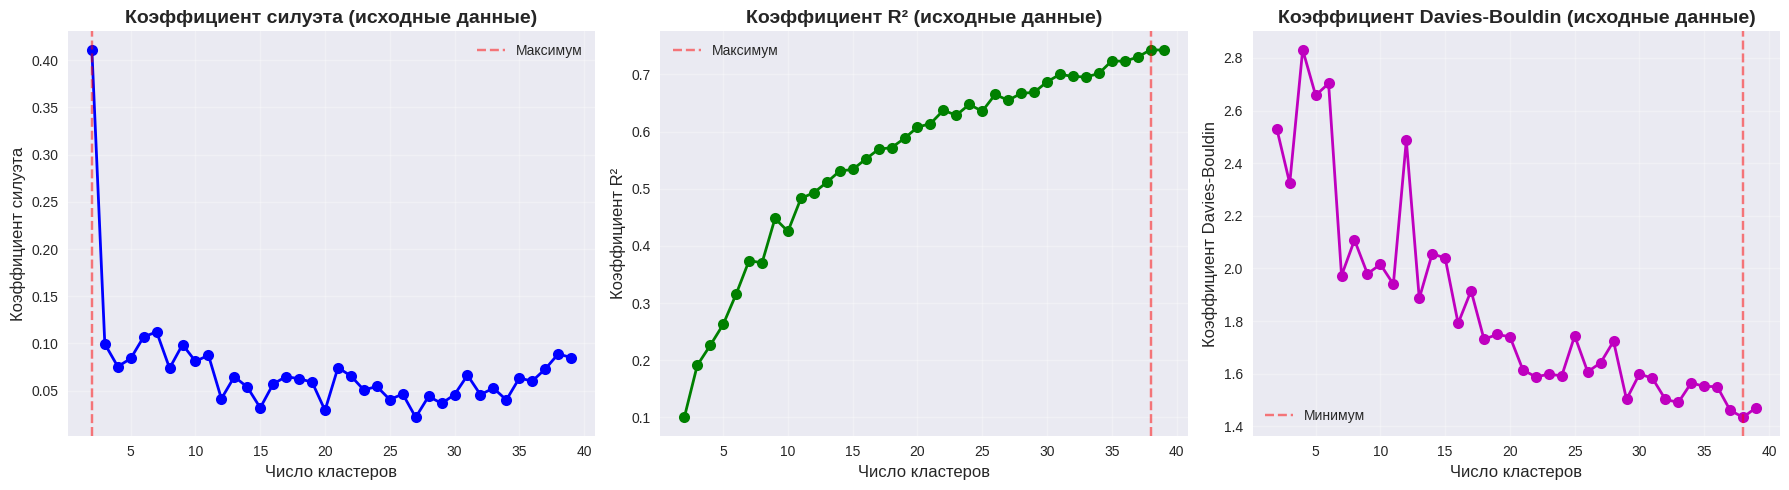

 n_clusters  silhouette  davies_bouldin       r2
          2    0.411028        2.531369 0.100185
          3    0.099511        2.323292 0.191258
          4    0.075490        2.831319 0.226054
          5    0.084072        2.657834 0.262754
          6    0.107034        2.703001 0.315736
          7    0.112204        1.972653 0.374461
          8    0.073790        2.107861 0.370468
          9    0.098829        1.979408 0.448128
         10    0.081052        2.015320 0.425591
         11    0.087552        1.940051 0.483142
         12    0.041493        2.486340 0.493294
         13    0.064824        1.885931 0.511354
         14    0.053775        2.055878 0.531195
         15    0.031841        2.039379 0.533815
         16    0.057137        1.791142 0.551913
         17    0.064969        1.914942 0.569226
         18    0.062541        1.730350 0.572064
         19    0.059145        1.748694 0.588375
         20    0.029152        1.740288 0.607855
         21    0.074

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].plot(df_results_original['n_clusters'], df_results_original['silhouette'], 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Число кластеров', fontsize=12)
axes[0].set_ylabel('Коэффициент силуэта', fontsize=12)
axes[0].set_title('Коэффициент силуэта (исходные данные)', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].axvline(x=df_results_original.loc[df_results_original['silhouette'].idxmax(), 'n_clusters'],
                color='r', linestyle='--', alpha=0.5, label='Максимум')
axes[0].legend()

axes[1].plot(df_results_original['n_clusters'], df_results_original['r2'], 'go-', linewidth=2, markersize=8)
axes[1].set_xlabel('Число кластеров', fontsize=12)
axes[1].set_ylabel('Коэффициент R²', fontsize=12)
axes[1].set_title('Коэффициент R² (исходные данные)', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].axvline(x=df_results_original.loc[df_results_original['r2'].idxmax(), 'n_clusters'],
                color='r', linestyle='--', alpha=0.5, label='Максимум')
axes[1].legend()

axes[2].plot(df_results_original['n_clusters'], df_results_original['davies_bouldin'], 'mo-', linewidth=2, markersize=8)
axes[2].set_xlabel('Число кластеров', fontsize=12)
axes[2].set_ylabel('Коэффициент Davies-Bouldin', fontsize=12)
axes[2].set_title('Коэффициент Davies-Bouldin (исходные данные)', fontsize=14, fontweight='bold')
axes[2].grid(True, alpha=0.3)
axes[2].axvline(x=df_results_original.loc[df_results_original['davies_bouldin'].idxmin(), 'n_clusters'],
                color='r', linestyle='--', alpha=0.5, label='Минимум')
axes[2].legend()

plt.tight_layout()
plt.show()

print(df_results_original.to_string(index=False))

In [15]:
df_results_original_norm = df_results_original.copy()
df_results_original_norm['silhouette_norm'] = df_results_original['silhouette']
df_results_original_norm['r2_norm'] = df_results_original['r2']
db_max = df_results_original['davies_bouldin'].max()
db_min = df_results_original['davies_bouldin'].min()
if db_max != db_min:
    df_results_original_norm['db_norm'] = 1 - (df_results_original['davies_bouldin'] - db_min) / (db_max - db_min)
else:
    df_results_original_norm['db_norm'] = 1.0

df_results_original_norm['composite_score'] = (
    df_results_original_norm['silhouette_norm'] +
    df_results_original_norm['r2_norm'] +
    df_results_original_norm['db_norm']
) / 3

best_k_original = df_results_original_norm.loc[df_results_original_norm['composite_score'].idxmax(), 'n_clusters']
best_idx_original = df_results_original_norm['composite_score'].idxmax()

print(f"\nЛучшее решение для исходных данных: k={int(best_k_original)}")
print(f"Silhouette: {df_results_original.loc[best_idx_original, 'silhouette']:.4f}")
print(f"R²: {df_results_original.loc[best_idx_original, 'r2']:.4f}")
print(f"Davies-Bouldin: {df_results_original.loc[best_idx_original, 'davies_bouldin']:.4f}")
print(f"Комплексная оценка: {df_results_original_norm.loc[best_idx_original, 'composite_score']:.4f}")

best_labels_original = results_original['labels'][best_idx_original]


Лучшее решение для исходных данных: k=38
Silhouette: 0.0889
R²: 0.7434
Davies-Bouldin: 1.4338
Комплексная оценка: 0.6107


## 5. Используя алгоритм кластеризации GMM и данные из двух признаков SVD:


In [16]:
# Кластеризация GMM на SVD-данных для k от 2 до 10
results_svd = {}
results_svd['n_clusters'] = []
results_svd['silhouette'] = []
results_svd['davies_bouldin'] = []
results_svd['r2'] = []
results_svd['models'] = []
results_svd['labels'] = []

print("Кластеризация GMM на SVD-данных...")
for k in K_range:
    gmm = GaussianMixture(n_components=k, random_state=42, n_init=10)
    labels = gmm.fit_predict(X_svd)
    silhouette = silhouette_score(X_svd, labels)
    db_score = davies_bouldin_score(X_svd, labels)
    centers = gmm.means_
    r2 = calculate_r2_score(X_svd, labels, centers)

    results_svd['n_clusters'].append(k)
    results_svd['silhouette'].append(silhouette)
    results_svd['davies_bouldin'].append(db_score)
    results_svd['r2'].append(r2)
    results_svd['models'].append(gmm)
    results_svd['labels'].append(labels)

    print(f"k={k}: Silhouette={silhouette:.4f}, DB={db_score:.4f}, R²={r2:.4f}")

df_results_svd = pd.DataFrame({
    'n_clusters': results_svd['n_clusters'],
    'silhouette': results_svd['silhouette'],
    'davies_bouldin': results_svd['davies_bouldin'],
    'r2': results_svd['r2']
})


Кластеризация GMM на SVD-данных...
k=2: Silhouette=0.6849, DB=0.9027, R²=0.3620
k=3: Silhouette=0.3645, DB=0.9524, R²=0.5293
k=4: Silhouette=0.3710, DB=0.9412, R²=0.6115
k=5: Silhouette=0.3754, DB=0.8779, R²=0.6885
k=6: Silhouette=0.3362, DB=0.9207, R²=0.7471
k=7: Silhouette=0.3506, DB=0.7891, R²=0.7702
k=8: Silhouette=0.3563, DB=0.7569, R²=0.8134
k=9: Silhouette=0.2980, DB=0.8539, R²=0.8278
k=10: Silhouette=0.3347, DB=0.8581, R²=0.8125
k=11: Silhouette=0.3065, DB=0.8197, R²=0.8684
k=12: Silhouette=0.3331, DB=0.7728, R²=0.8762
k=13: Silhouette=0.3151, DB=0.7808, R²=0.8821
k=14: Silhouette=0.3090, DB=0.7972, R²=0.8890
k=15: Silhouette=0.2944, DB=0.8556, R²=0.8968
k=16: Silhouette=0.2917, DB=0.8402, R²=0.9040
k=17: Silhouette=0.3101, DB=0.8045, R²=0.9091
k=18: Silhouette=0.2898, DB=0.8546, R²=0.9201
k=19: Silhouette=0.3021, DB=0.8865, R²=0.9212
k=20: Silhouette=0.2812, DB=0.8236, R²=0.9250
k=21: Silhouette=0.3000, DB=0.8262, R²=0.9271
k=22: Silhouette=0.2962, DB=0.8014, R²=0.9358
k=23: S

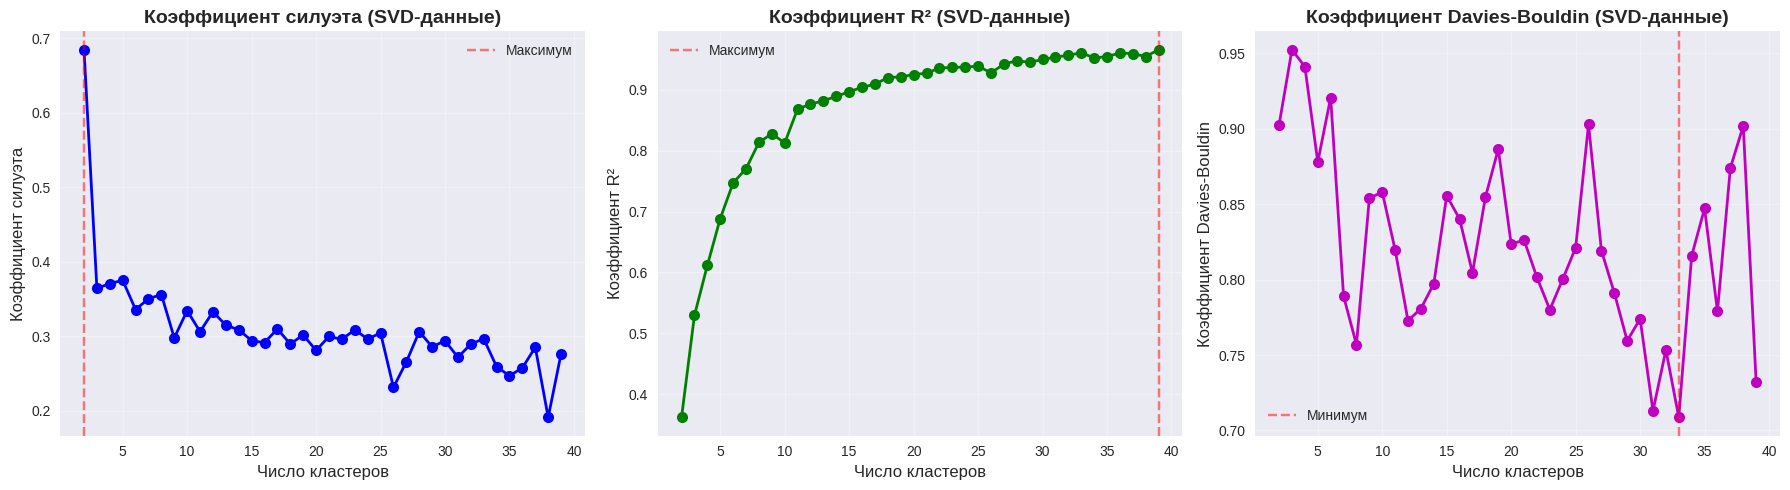

 n_clusters  silhouette  davies_bouldin       r2
          2    0.684900        0.902670 0.361983
          3    0.364514        0.952396 0.529287
          4    0.371019        0.941167 0.611476
          5    0.375415        0.877927 0.688453
          6    0.336159        0.920692 0.747058
          7    0.350591        0.789074 0.770225
          8    0.356324        0.756894 0.813425
          9    0.298048        0.853915 0.827841
         10    0.334730        0.858116 0.812527
         11    0.306456        0.819674 0.868417
         12    0.333137        0.772769 0.876196
         13    0.315147        0.780827 0.882121
         14    0.308955        0.797244 0.889027
         15    0.294407        0.855609 0.896835
         16    0.291672        0.840244 0.904001
         17    0.310100        0.804481 0.909083
         18    0.289812        0.854600 0.920095
         19    0.302123        0.886511 0.921154
         20    0.281186        0.823595 0.924961
         21    0.300

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].plot(df_results_svd['n_clusters'], df_results_svd['silhouette'], 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Число кластеров', fontsize=12)
axes[0].set_ylabel('Коэффициент силуэта', fontsize=12)
axes[0].set_title('Коэффициент силуэта (SVD-данные)', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].axvline(x=df_results_svd.loc[df_results_svd['silhouette'].idxmax(), 'n_clusters'],
                color='r', linestyle='--', alpha=0.5, label='Максимум')
axes[0].legend()

axes[1].plot(df_results_svd['n_clusters'], df_results_svd['r2'], 'go-', linewidth=2, markersize=8)
axes[1].set_xlabel('Число кластеров', fontsize=12)
axes[1].set_ylabel('Коэффициент R²', fontsize=12)
axes[1].set_title('Коэффициент R² (SVD-данные)', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].axvline(x=df_results_svd.loc[df_results_svd['r2'].idxmax(), 'n_clusters'],
                color='r', linestyle='--', alpha=0.5, label='Максимум')
axes[1].legend()

axes[2].plot(df_results_svd['n_clusters'], df_results_svd['davies_bouldin'], 'mo-', linewidth=2, markersize=8)
axes[2].set_xlabel('Число кластеров', fontsize=12)
axes[2].set_ylabel('Коэффициент Davies-Bouldin', fontsize=12)
axes[2].set_title('Коэффициент Davies-Bouldin (SVD-данные)', fontsize=14, fontweight='bold')
axes[2].grid(True, alpha=0.3)
axes[2].axvline(x=df_results_svd.loc[df_results_svd['davies_bouldin'].idxmin(), 'n_clusters'],
                color='r', linestyle='--', alpha=0.5, label='Минимум')
axes[2].legend()

plt.tight_layout()
plt.show()

print(df_results_svd.to_string(index=False))


In [18]:
df_results_svd_norm = df_results_svd.copy()
df_results_svd_norm['silhouette_norm'] = df_results_svd['silhouette']
df_results_svd_norm['r2_norm'] = df_results_svd['r2']
db_max_svd = df_results_svd['davies_bouldin'].max()
db_min_svd = df_results_svd['davies_bouldin'].min()
if db_max_svd != db_min_svd:
    df_results_svd_norm['db_norm'] = 1 - (df_results_svd['davies_bouldin'] - db_min_svd) / (db_max_svd - db_min_svd)
else:
    df_results_svd_norm['db_norm'] = 1.0

df_results_svd_norm['composite_score'] = (
    df_results_svd_norm['silhouette_norm'] +
    df_results_svd_norm['r2_norm'] +
    df_results_svd_norm['db_norm']
) / 3

best_idx_svd = df_results_svd_norm['composite_score'].idxmax()
best_k_svd = df_results_svd_norm.loc[best_idx_svd, 'n_clusters']

print(f"\nЛучшее решение для SVD-данных: k={int(best_k_svd)}")
print(f"Silhouette: {df_results_svd.loc[best_idx_svd, 'silhouette']:.4f}")
print(f"R²: {df_results_svd.loc[best_idx_svd, 'r2']:.4f}")
print(f"Davies-Bouldin: {df_results_svd.loc[best_idx_svd, 'davies_bouldin']:.4f}")
print(f"Комплексная оценка: {df_results_svd_norm.loc[best_idx_svd, 'composite_score']:.4f}")

best_labels_svd = results_svd['labels'][best_idx_svd]



Лучшее решение для SVD-данных: k=33
Silhouette: 0.2970
R²: 0.9609
Davies-Bouldin: 0.7087
Комплексная оценка: 0.7526



СРАВНЕНИЕ ЛУЧШИХ РЕШЕНИЙ

Исходные данные (k=38):
  Silhouette: 0.0889
  R²: 0.7434
  Davies-Bouldin: 1.4338

SVD-данные (k=33):
  Silhouette: 0.2970
  R²: 0.9609
  Davies-Bouldin: 0.7087


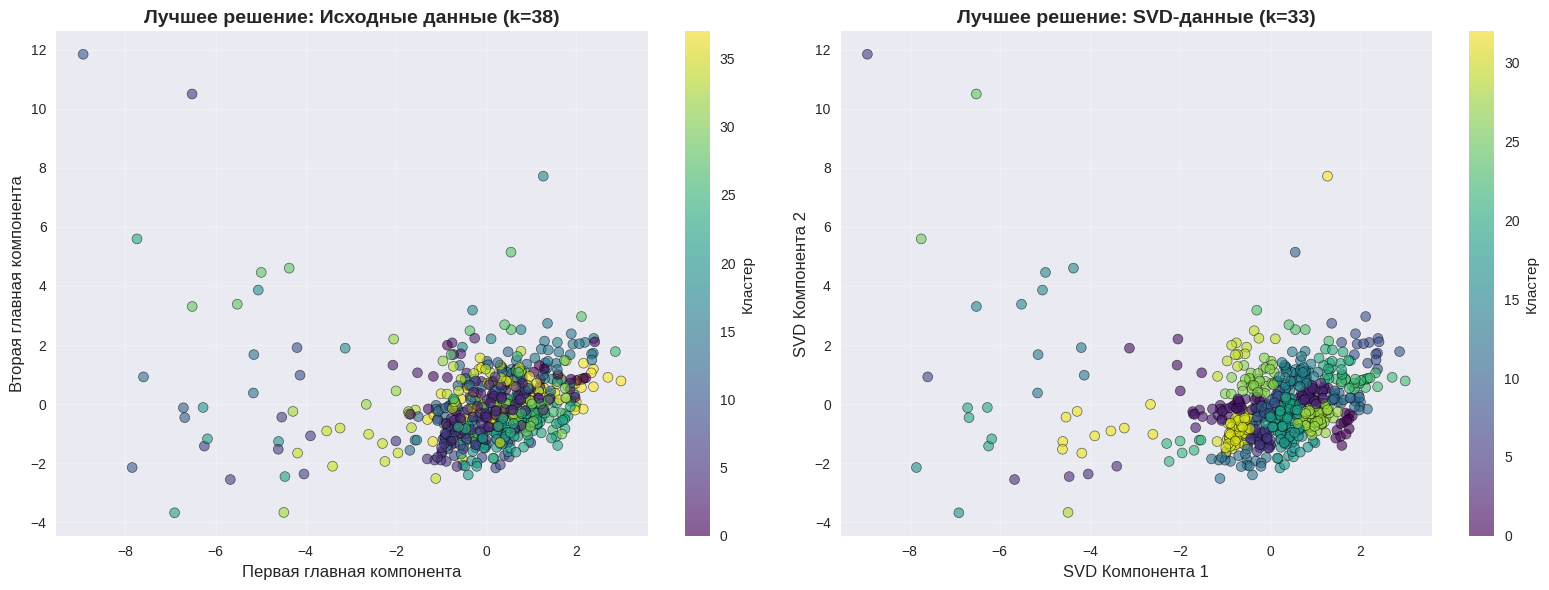

In [19]:
print("\n" + "="*60)
print("СРАВНЕНИЕ ЛУЧШИХ РЕШЕНИЙ")
print("="*60)
print(f"\nИсходные данные (k={int(best_k_original)}):")
print(f"  Silhouette: {df_results_original.loc[best_idx_original, 'silhouette']:.4f}")
print(f"  R²: {df_results_original.loc[best_idx_original, 'r2']:.4f}")
print(f"  Davies-Bouldin: {df_results_original.loc[best_idx_original, 'davies_bouldin']:.4f}")

print(f"\nSVD-данные (k={int(best_k_svd)}):")
print(f"  Silhouette: {df_results_svd.loc[best_idx_svd, 'silhouette']:.4f}")
print(f"  R²: {df_results_svd.loc[best_idx_svd, 'r2']:.4f}")
print(f"  Davies-Bouldin: {df_results_svd.loc[best_idx_svd, 'davies_bouldin']:.4f}")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

from sklearn.decomposition import PCA
pca_vis = PCA(n_components=2, random_state=42)
X_pca_vis = pca_vis.fit_transform(df_scaled)

scatter1 = axes[0].scatter(X_pca_vis[:, 0], X_pca_vis[:, 1], c=best_labels_original,
                          cmap='viridis', alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
axes[0].set_xlabel('Первая главная компонента', fontsize=12)
axes[0].set_ylabel('Вторая главная компонента', fontsize=12)
axes[0].set_title(f'Лучшее решение: Исходные данные (k={int(best_k_original)})', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
plt.colorbar(scatter1, ax=axes[0], label='Кластер')

scatter2 = axes[1].scatter(X_svd[:, 0], X_svd[:, 1], c=best_labels_svd,
                          cmap='viridis', alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
axes[1].set_xlabel('SVD Компонента 1', fontsize=12)
axes[1].set_ylabel('SVD Компонента 2', fontsize=12)
axes[1].set_title(f'Лучшее решение: SVD-данные (k={int(best_k_svd)})', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
plt.colorbar(scatter2, ax=axes[1], label='Кластер')

plt.tight_layout()
plt.show()


## 7. Сравнение решений с помощью индекса Rand


In [20]:
n_solutions = len(K_range)
rand_matrix = np.zeros((n_solutions, n_solutions), dtype=float)

print("\nСравнение решений:")
for i, k1 in enumerate(K_range):
    for j, k2 in enumerate(K_range):
        if i <= j:
            rand_score = adjusted_rand_score(results_original['labels'][i], results_original['labels'][j])
            rand_matrix[i, j] = rand_score
            if i == j:
                print(f"  k={k1} vs k={k2}: {rand_score:.4f} (одинаковое решение)")

print("\nСравнение решений на SVD:")
for i, k1 in enumerate(K_range):
    for j, k2 in enumerate(K_range):
        if i <= j:
            rand_score = adjusted_rand_score(results_svd['labels'][i], results_svd['labels'][j])
            if i == j:
                print(f"  k={k1} vs k={k2}: {rand_score:.4f} (одинаковое решение)")

print("\nСравнение лучших решений:")
best_rand_score = adjusted_rand_score(best_labels_original, best_labels_svd)
print(f"  Исходные данные (k={int(best_k_original)}) vs SVD-данные (k={int(best_k_svd)}): {best_rand_score:.4f}")



Сравнение решений:
  k=2 vs k=2: 1.0000 (одинаковое решение)
  k=3 vs k=3: 1.0000 (одинаковое решение)
  k=4 vs k=4: 1.0000 (одинаковое решение)
  k=5 vs k=5: 1.0000 (одинаковое решение)
  k=6 vs k=6: 1.0000 (одинаковое решение)
  k=7 vs k=7: 1.0000 (одинаковое решение)
  k=8 vs k=8: 1.0000 (одинаковое решение)
  k=9 vs k=9: 1.0000 (одинаковое решение)
  k=10 vs k=10: 1.0000 (одинаковое решение)
  k=11 vs k=11: 1.0000 (одинаковое решение)
  k=12 vs k=12: 1.0000 (одинаковое решение)
  k=13 vs k=13: 1.0000 (одинаковое решение)
  k=14 vs k=14: 1.0000 (одинаковое решение)
  k=15 vs k=15: 1.0000 (одинаковое решение)
  k=16 vs k=16: 1.0000 (одинаковое решение)
  k=17 vs k=17: 1.0000 (одинаковое решение)
  k=18 vs k=18: 1.0000 (одинаковое решение)
  k=19 vs k=19: 1.0000 (одинаковое решение)
  k=20 vs k=20: 1.0000 (одинаковое решение)
  k=21 vs k=21: 1.0000 (одинаковое решение)
  k=22 vs k=22: 1.0000 (одинаковое решение)
  k=23 vs k=23: 1.0000 (одинаковое решение)
  k=24 vs k=24: 1.0000 (один

Сравнение всех решений:


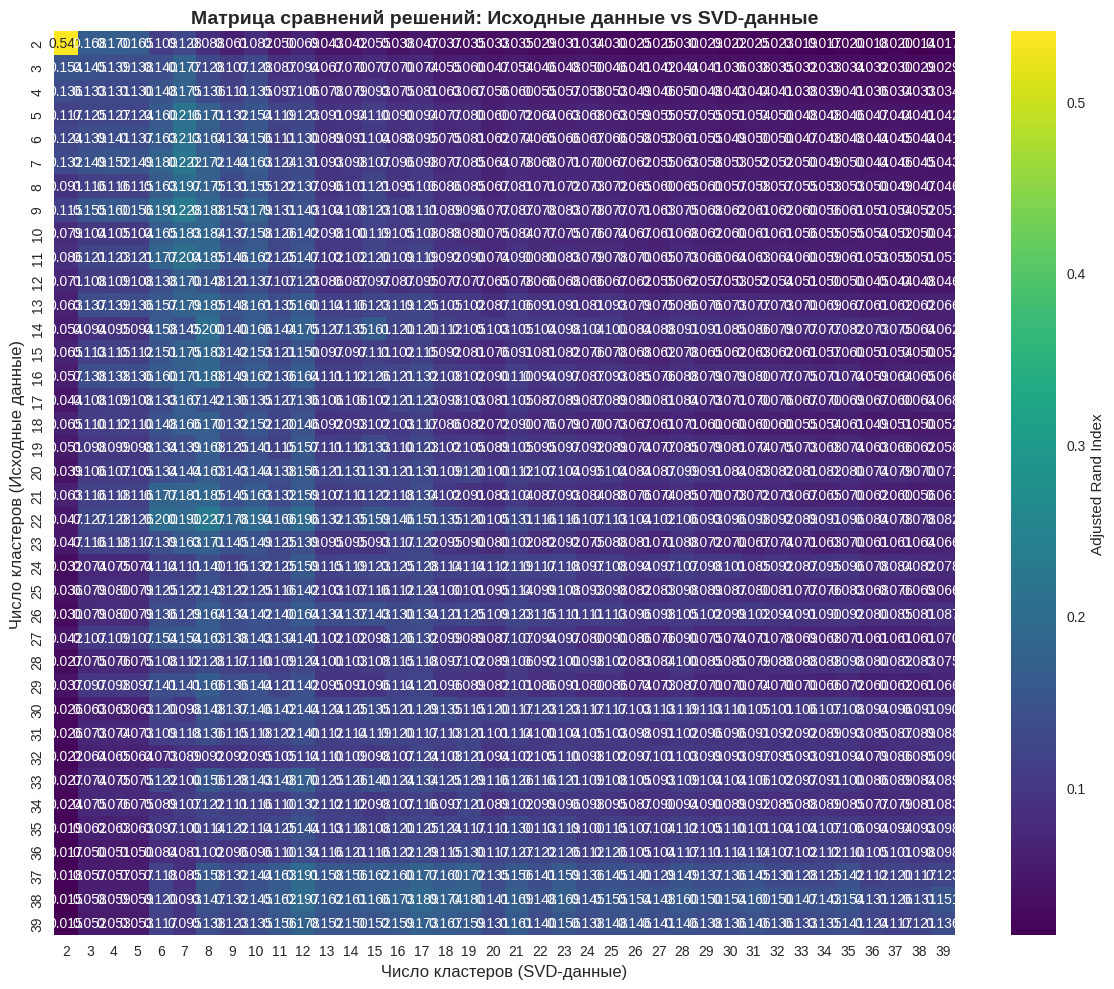


Максимальное совпадение:
  k_original=2, k_svd=2, Rand Index=0.5408


In [21]:
print("Сравнение всех решений:")

comparison_results = []
for i, k_orig in enumerate(K_range):
    for j, k_svd in enumerate(K_range):
        rand_score = adjusted_rand_score(results_original['labels'][i], results_svd['labels'][j])
        comparison_results.append({
            'k_original': k_orig,
            'k_svd': k_svd,
            'rand_index': rand_score
        })

df_comparison = pd.DataFrame(comparison_results)
pivot_table = df_comparison.pivot(index='k_original', columns='k_svd', values='rand_index')

# Визуализация матрицы сравнений
plt.figure(figsize=(12, 10))
sns.heatmap(pivot_table, annot=True, fmt='.3f', cmap='viridis', cbar_kws={'label': 'Adjusted Rand Index'})
plt.title('Матрица сравнений решений: Исходные данные vs SVD-данные', fontsize=14, fontweight='bold')
plt.xlabel('Число кластеров (SVD-данные)', fontsize=12)
plt.ylabel('Число кластеров (Исходные данные)', fontsize=12)
plt.tight_layout()
plt.show()

print("\nМаксимальное совпадение:")
max_idx = df_comparison['rand_index'].idxmax()
print(f"  k_original={int(df_comparison.loc[max_idx, 'k_original'])}, "
      f"k_svd={int(df_comparison.loc[max_idx, 'k_svd'])}, "
      f"Rand Index={df_comparison.loc[max_idx, 'rand_index']:.4f}")


In [22]:
print("Объекты которые все решения помещают вместе")

n_samples = len(best_labels_original)
agreement_matrix_original = np.zeros((n_samples, n_samples), dtype=float)

for labels in results_original['labels']:
    for i in range(n_samples):
        for j in range(i+1, n_samples):
            if labels[i] == labels[j]:
                agreement_matrix_original[i, j] += 1
                agreement_matrix_original[j, i] += 1

agreement_matrix_original = agreement_matrix_original / len(results_original['labels'])

always_together_original = []
for i in range(n_samples):
    for j in range(i+1, n_samples):
        if agreement_matrix_original[i, j] == 1.0:
            always_together_original.append((i, j))

print(f"  Всего пар объектов, которые всегда вместе: {len(always_together_original)}")

agreement_matrix_svd = np.zeros((n_samples, n_samples), dtype=float)

for labels in results_svd['labels']:
    for i in range(n_samples):
        for j in range(i+1, n_samples):
            if labels[i] == labels[j]:
                agreement_matrix_svd[i, j] += 1
                agreement_matrix_svd[j, i] += 1

agreement_matrix_svd = agreement_matrix_svd / len(results_svd['labels'])

always_together_svd = []
for i in range(n_samples):
    for j in range(i+1, n_samples):
        if agreement_matrix_svd[i, j] == 1.0:
            always_together_svd.append((i, j))

print(f"\nДля SVD-данных:")
print(f"  Всего пар объектов, которые всегда вместе: {len(always_together_svd)}")


Объекты которые все решения помещают вместе
  Всего пар объектов, которые всегда вместе: 60

Для SVD-данных:
  Всего пар объектов, которые всегда вместе: 336


граничные объекты

Для исходных данных:
  Граничных объектов (согласованность < 0.5): 589
  Средняя согласованность: 0.1842
  Медианная согласованность: 0.2158

Для SVD-данных:
  Граничных объектов (согласованность < 0.5): 589
  Средняя согласованность: 0.1565
  Медианная согласованность: 0.1690


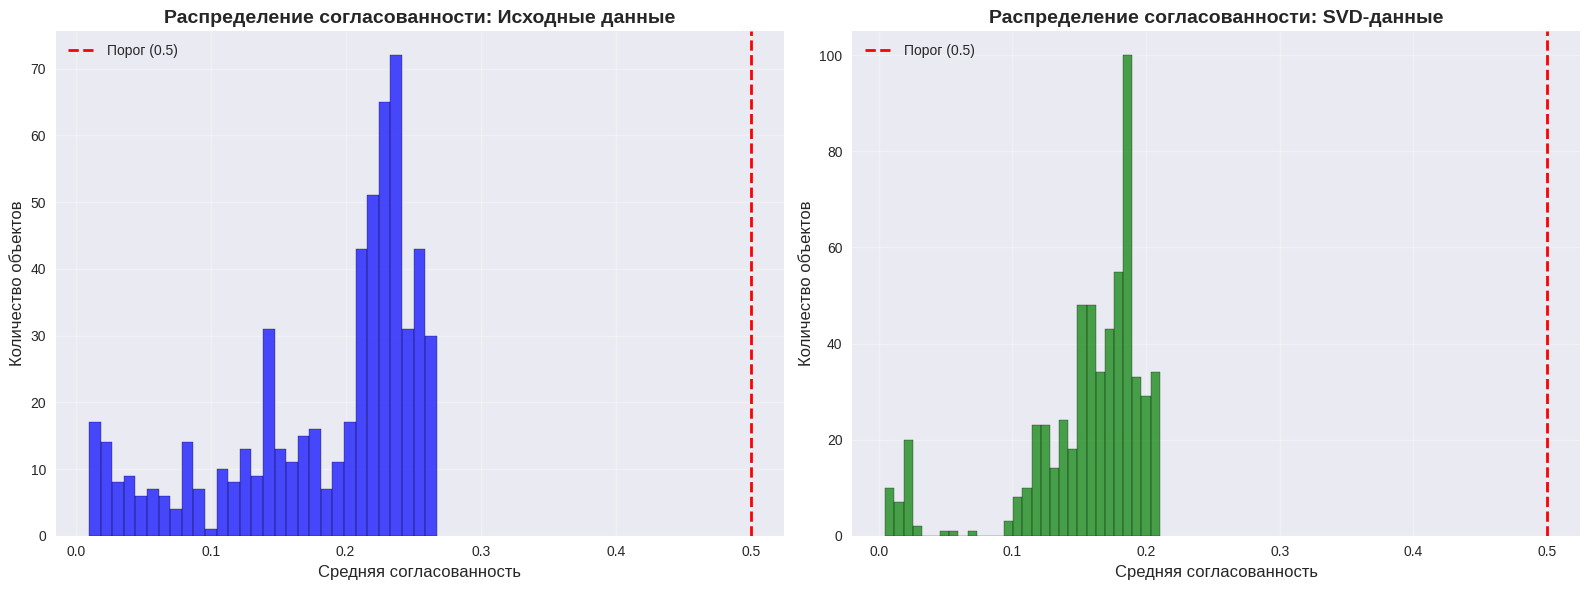

In [23]:
print("граничные объекты")

avg_agreement_original = np.mean(agreement_matrix_original, axis=1)
boundary_threshold = 0.5  # Порог для определения граничных объектов
boundary_objects_original = np.where(avg_agreement_original < boundary_threshold)[0]

print(f"\nДля исходных данных:")
print(f"  Граничных объектов (согласованность < {boundary_threshold}): {len(boundary_objects_original)}")
print(f"  Средняя согласованность: {np.mean(avg_agreement_original):.4f}")
print(f"  Медианная согласованность: {np.median(avg_agreement_original):.4f}")

# Для SVD-данных
avg_agreement_svd = np.mean(agreement_matrix_svd, axis=1)
boundary_objects_svd = np.where(avg_agreement_svd < boundary_threshold)[0]

print(f"\nДля SVD-данных:")
print(f"  Граничных объектов (согласованность < {boundary_threshold}): {len(boundary_objects_svd)}")
print(f"  Средняя согласованность: {np.mean(avg_agreement_svd):.4f}")
print(f"  Медианная согласованность: {np.median(avg_agreement_svd):.4f}")

# Визуализация согласованности
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].hist(avg_agreement_original, bins=30, alpha=0.7, edgecolor='black', color='blue')
axes[0].axvline(boundary_threshold, color='red', linestyle='--', linewidth=2, label=f'Порог ({boundary_threshold})')
axes[0].set_xlabel('Средняя согласованность', fontsize=12)
axes[0].set_ylabel('Количество объектов', fontsize=12)
axes[0].set_title('Распределение согласованности: Исходные данные', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].hist(avg_agreement_svd, bins=30, alpha=0.7, edgecolor='black', color='green')
axes[1].axvline(boundary_threshold, color='red', linestyle='--', linewidth=2, label=f'Порог ({boundary_threshold})')
axes[1].set_xlabel('Средняя согласованность', fontsize=12)
axes[1].set_ylabel('Количество объектов', fontsize=12)
axes[1].set_title('Распределение согласованности: SVD-данные', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


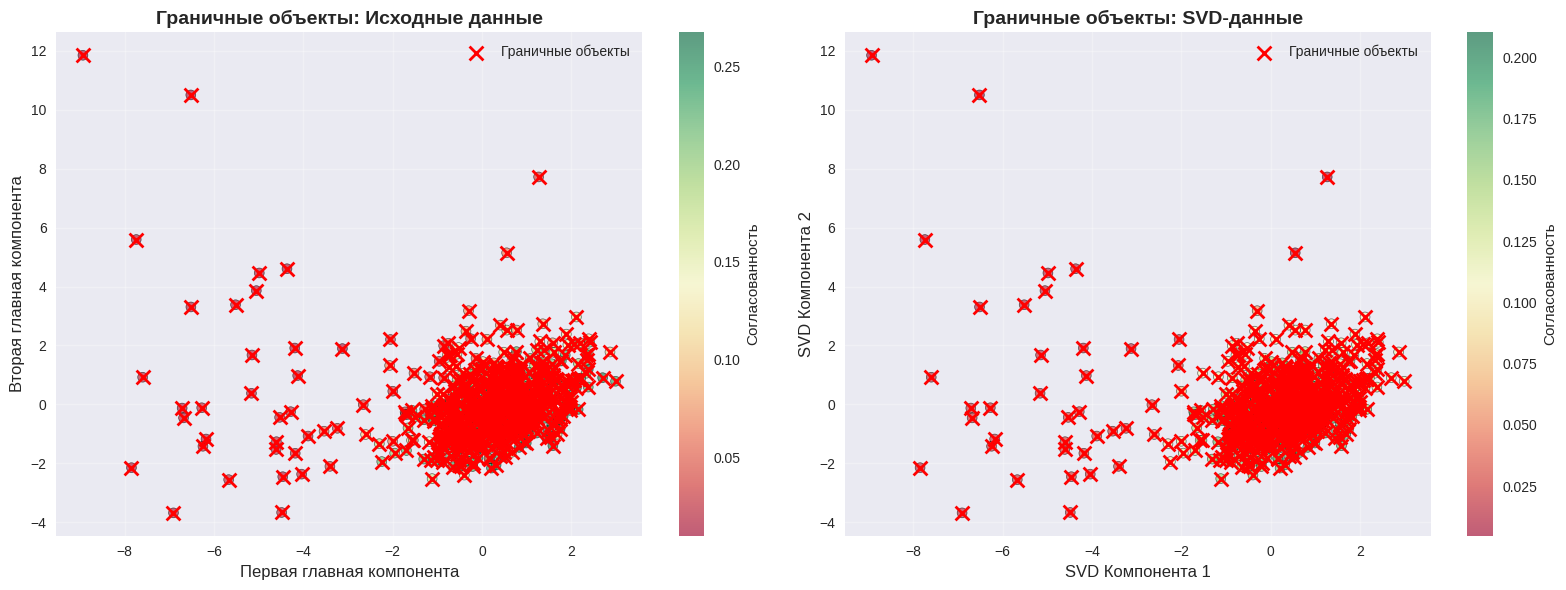

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

scatter1 = axes[0].scatter(X_pca_vis[:, 0], X_pca_vis[:, 1],
                          c=avg_agreement_original, cmap='RdYlGn',
                          alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
axes[0].scatter(X_pca_vis[boundary_objects_original, 0],
               X_pca_vis[boundary_objects_original, 1],
               c='red', marker='x', s=100, linewidths=2, label='Граничные объекты')
axes[0].set_xlabel('Первая главная компонента', fontsize=12)
axes[0].set_ylabel('Вторая главная компонента', fontsize=12)
axes[0].set_title('Граничные объекты: Исходные данные', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
plt.colorbar(scatter1, ax=axes[0], label='Согласованность')

# SVD-данные
scatter2 = axes[1].scatter(X_svd[:, 0], X_svd[:, 1],
                          c=avg_agreement_svd, cmap='RdYlGn',
                          alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
axes[1].scatter(X_svd[boundary_objects_svd, 0],
               X_svd[boundary_objects_svd, 1],
               c='red', marker='x', s=100, linewidths=2, label='Граничные объекты')
axes[1].set_xlabel('SVD Компонента 1', fontsize=12)
axes[1].set_ylabel('SVD Компонента 2', fontsize=12)
axes[1].set_title('Граничные объекты: SVD-данные', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
plt.colorbar(scatter2, ax=axes[1], label='Согласованность')

plt.tight_layout()
plt.show()


Исходные данные vs SVD-данные

Корреляция между согласованностями: 0.6514

Статистика согласованности:
  Исходные данные:
    Среднее: 0.1842
    Медиана: 0.2158
    Стандартное отклонение: 0.0714
    Минимум: 0.0099
    Максимум: 0.2675

  SVD-данные:
    Среднее: 0.1565
    Медиана: 0.1690
    Стандартное отклонение: 0.0457
    Минимум: 0.0048
    Максимум: 0.2102


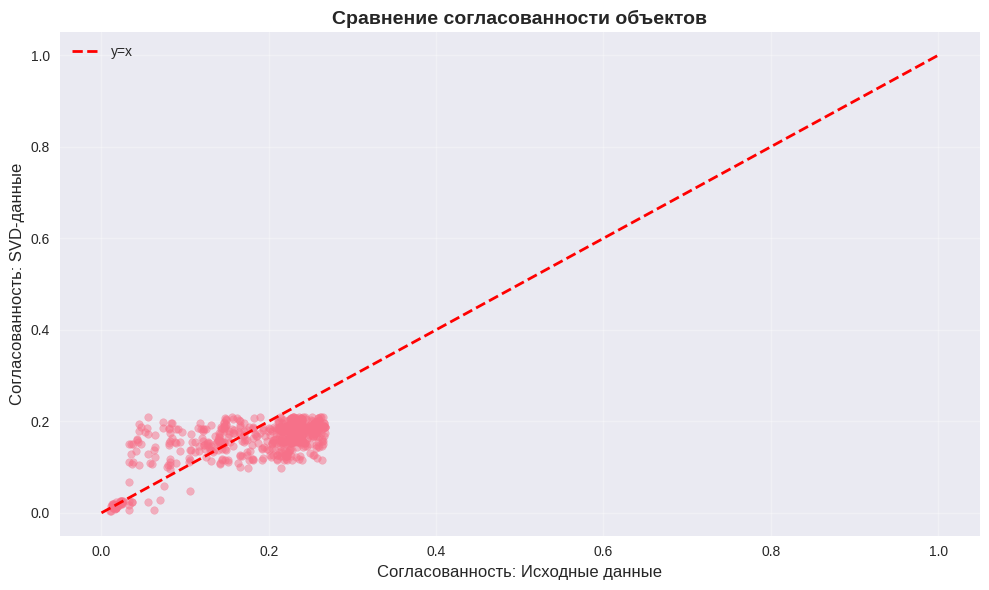

In [25]:
print("Исходные данные vs SVD-данные")

correlation = np.corrcoef(avg_agreement_original, avg_agreement_svd)[0, 1]
print(f"\nКорреляция между согласованностями: {correlation:.4f}")

print(f"\nСтатистика согласованности:")
print(f"  Исходные данные:")
print(f"    Среднее: {np.mean(avg_agreement_original):.4f}")
print(f"    Медиана: {np.median(avg_agreement_original):.4f}")
print(f"    Стандартное отклонение: {np.std(avg_agreement_original):.4f}")
print(f"    Минимум: {np.min(avg_agreement_original):.4f}")
print(f"    Максимум: {np.max(avg_agreement_original):.4f}")

print(f"\n  SVD-данные:")
print(f"    Среднее: {np.mean(avg_agreement_svd):.4f}")
print(f"    Медиана: {np.median(avg_agreement_svd):.4f}")
print(f"    Стандартное отклонение: {np.std(avg_agreement_svd):.4f}")
print(f"    Минимум: {np.min(avg_agreement_svd):.4f}")
print(f"    Максимум: {np.max(avg_agreement_svd):.4f}")

plt.figure(figsize=(10, 6))
plt.scatter(avg_agreement_original, avg_agreement_svd, alpha=0.5, s=30)
plt.plot([0, 1], [0, 1], 'r--', linewidth=2, label='y=x')
plt.xlabel('Согласованность: Исходные данные', fontsize=12)
plt.ylabel('Согласованность: SVD-данные', fontsize=12)
plt.title('Сравнение согласованности объектов', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## Выводы


In [26]:
print("таблица метрик")

comparison_summary = pd.DataFrame({
    'Метрика': ['Silhouette (лучшее)', 'R² (лучшее)', 'Davies-Bouldin (лучшее)',
                'Число кластеров (лучшее)', 'Средняя согласованность',
                'Граничные объекты (%)', 'Rand Index (лучшие решения)'],
    'Исходные данные': [
        f"{df_results_original.loc[best_idx_original, 'silhouette']:.4f}",
        f"{df_results_original.loc[best_idx_original, 'r2']:.4f}",
        f"{df_results_original.loc[best_idx_original, 'davies_bouldin']:.4f}",
        f"{int(best_k_original)}",
        f"{np.mean(avg_agreement_original):.4f}",
        f"{len(boundary_objects_original)/n_samples*100:.2f}%",
        f"{best_rand_score:.4f}"
    ],
    'SVD-данные': [
        f"{df_results_svd.loc[best_idx_svd, 'silhouette']:.4f}",
        f"{df_results_svd.loc[best_idx_svd, 'r2']:.4f}",
        f"{df_results_svd.loc[best_idx_svd, 'davies_bouldin']:.4f}",
        f"{int(best_k_svd)}",
        f"{np.mean(avg_agreement_svd):.4f}",
        f"{len(boundary_objects_svd)/n_samples*100:.2f}%",
        f"{best_rand_score:.4f}"
    ]
})

print("\n", comparison_summary.to_string(index=False))

print("вывод")

silhouette_improvement = df_results_svd.loc[best_idx_svd, 'silhouette'] - df_results_original.loc[best_idx_original, 'silhouette']
r2_improvement = df_results_svd.loc[best_idx_svd, 'r2'] - df_results_original.loc[best_idx_original, 'r2']
db_improvement = df_results_original.loc[best_idx_original, 'davies_bouldin'] - df_results_svd.loc[best_idx_svd, 'davies_bouldin']  # Обратный знак, т.к. меньше = лучше
agreement_improvement = np.mean(avg_agreement_svd) - np.mean(avg_agreement_original)

print(f"\n1. Сравнение метрик качества кластеризации:")
print(f"   - Silhouette: {'улучшение' if silhouette_improvement > 0 else 'ухудшение'} на {abs(silhouette_improvement):.4f}")
print(f"   - R²: {'улучшение' if r2_improvement > 0 else 'ухудшение'} на {abs(r2_improvement):.4f}")
print(f"   - Davies-Bouldin: {'улучшение' if db_improvement > 0 else 'ухудшение'} на {abs(db_improvement):.4f}")

print(f"\n2. Согласованность решений:")
print(f"   - Средняя согласованность: {'выше' if agreement_improvement > 0 else 'ниже'} на {abs(agreement_improvement):.4f} для SVD-данных")
print(f"   - Граничных объектов: {len(boundary_objects_svd)} (SVD) vs {len(boundary_objects_original)} (исходные)")

print(f"\n3. Сравнение решений (Rand Index):")
print(f"   - Индекс Rand между лучшими решениями: {best_rand_score:.4f}")
if best_rand_score > 0.5:
    print(f"   - Решения достаточно схожи (Rand Index > 0.5)")
elif best_rand_score > 0.3:
    print(f"   - Решения умеренно схожи (0.3 < Rand Index < 0.5)")
else:
    print(f"   - Решения существенно различаются (Rand Index < 0.3)")

print(f"\n4. итог:")
if silhouette_improvement > 0 and r2_improvement > 0 and db_improvement > 0:
    conclusion = "SVD-преобразование УЛУЧШАЕТ качество кластеризации"
elif silhouette_improvement < 0 and r2_improvement < 0 and db_improvement < 0:
    conclusion = "SVD-преобразование УХУДШАЕТ качество кластеризации"
else:
    conclusion = "SVD-преобразование дает СМЕШАННЫЕ результаты"

print(f"   {conclusion}")
print(f"   - Лучшее число кластеров для исходных данных: {int(best_k_original)}")
print(f"   - Лучшее число кластеров для SVD-данных: {int(best_k_svd)}")
print(f"   - SVD объясняет {cumulative_variance[1]*100:.2f}% дисперсии данных")


таблица метрик

                     Метрика Исходные данные SVD-данные
        Silhouette (лучшее)          0.0889     0.2970
                R² (лучшее)          0.7434     0.9609
    Davies-Bouldin (лучшее)          1.4338     0.7087
   Число кластеров (лучшее)              38         33
    Средняя согласованность          0.1842     0.1565
      Граничные объекты (%)         100.00%    100.00%
Rand Index (лучшие решения)          0.1466     0.1466
вывод

1. Сравнение метрик качества кластеризации:
   - Silhouette: улучшение на 0.2081
   - R²: улучшение на 0.2175
   - Davies-Bouldin: улучшение на 0.7250

2. Согласованность решений:
   - Средняя согласованность: ниже на 0.0277 для SVD-данных
   - Граничных объектов: 589 (SVD) vs 589 (исходные)

3. Сравнение решений (Rand Index):
   - Индекс Rand между лучшими решениями: 0.1466
   - Решения существенно различаются (Rand Index < 0.3)

4. итог:
   SVD-преобразование УЛУЧШАЕТ качество кластеризации
   - Лучшее число кластеров для исходн